In [1]:
import torch
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
print(f'{device=}')

device='cuda'


In [2]:
with open('/home/holz/etc/git/makemore/names.txt', 'r') as fnames:
    names = [n.strip() for n in fnames.readlines()]
print(names[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
from string import ascii_lowercase

chars = '.' + ascii_lowercase
VOCABULARY_SIZE = len(chars)

In [4]:
ascii2idx = {}
idx2ascii = {}
for i, c in enumerate(chars):
    ascii2idx[c] = i
    idx2ascii[i] = c

def encode_str(s: str):
    senc = [ascii2idx[c] for c in s]
    return torch.tensor(senc)

def decode_char(c: torch.Tensor):
    return [idx2ascii[i.item()] for i in c]
    
def encode_dataset(xs, ys):
    xs_enc = []
    ygt_enc = []
    
    for xx, yy in zip(xs, ys):
        xenc = [ascii2idx[x] for x in xx] 
        yenc = ascii2idx[yy[0]]
        
        xs_enc.append(xenc)
        ygt_enc.append(yenc)
    
    return torch.tensor(xs_enc), torch.tensor(ygt_enc)

In [5]:
encode_str('.ab')

tensor([0, 1, 2], device='cuda:0')

In [6]:
decode_char(torch.tensor([0., 1., 2.,]))

['.', 'a', 'b']

In [7]:
CONTEXT_SIZE = 3

def build_dataset(words):
    xs  = []
    ygt = []
    
    context = '.' * CONTEXT_SIZE
    X = '.'.join(words) + '.'
    
    i = 0
    while i < len(X):
        next_char = X[i]
    
        xs.append(context)
        ygt.append(next_char)
     
        if next_char == '.':
            context = '...'
        else:
            context = context[1:] + next_char
    
        i += 1

    return encode_dataset(xs, ygt)

In [8]:
import random

random.seed(42)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

Xtr, Ytr   = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte   = build_dataset(names[n2:])

In [9]:
g = torch.Generator(device=device).manual_seed(2147483647)
EMB_DIM = 4 # Embeddings dimension

C = torch.randn((VOCABULARY_SIZE, EMB_DIM), generator=g)

W1 = torch.randn((CONTEXT_SIZE * EMB_DIM, 256), generator=g)
b1 = torch.randn(256, generator=g)

W2 = torch.randn((256, VOCABULARY_SIZE), generator=g)
b2 = torch.randn(VOCABULARY_SIZE, generator=g)

parameters = [C, W1, b1, W2, b2]
for pp in parameters:
    pp.requires_grad = True
    
nparams = sum(pp.nelement() for pp in parameters)
print(f'Number of parameters: {nparams}')

Number of parameters: 10375


In [10]:
def predict(C, W1, b1, W2, b2, context):
    context_enc = encode_str(context)

    emb    = C[context_enc]
    h      = torch.tanh(emb.view((-1, CONTEXT_SIZE * EMB_DIM)) @ W1 + b1)
    logits = h @ W2 + b2
    counts = logits.exp()
    prob   = counts / counts.sum(1, keepdim=True)

    return torch.multinomial(prob, num_samples=1, replacement=True)

In [11]:
def inference(C, W1, b1, W2, b2, X, Y):
    emb    = C[X]
    h      = torch.tanh(emb.view((-1, CONTEXT_SIZE * EMB_DIM)) @ W1 + b1)
    logits = h @ W2 + b2
    loss   = F.cross_entropy(logits, Y)

    return loss

In [12]:
def generate_name():
    context = '...'
    name = ''
    while True:
        c = predict(C, W1, b1, W2, b2, context)
        c = decode_char(c[0])[0]
    
        if c == '.':
            break
    
        name += c
        context = context[1:] + c
    
    return name

In [13]:
losses = []

In [14]:
max_steps = 1000 * 200
for lr in (1e-1, 1e-2, 1e-3, 1e-4):
    epoch = 0
    while epoch < max_steps:
        # minibatch
        ix = torch.randint(0, Xtr.shape[0], (512,))
        
        emb    = C[Xtr[ix]]
        h      = torch.tanh(emb.view((-1, CONTEXT_SIZE * EMB_DIM)) @ W1 + b1)
        logits = h @ W2 + b2
        loss   = F.cross_entropy(logits, Ytr[ix])
    
        for pp in parameters:
            pp.grad = None
        loss.backward()
    
        for pp in parameters:
            pp.data += -lr * pp.grad
    
        losses.append(loss.log10().item())
        
        if epoch % 50000 == 0:
            print(f'{epoch:7d}/{max_steps}: {loss.item():.4f}')
            
        epoch += 1
        
    loss_tr  = inference(C, W1, b1, W2, b2, Xtr, Ytr)
    loss_dev = inference(C, W1, b1, W2, b2, Xdev, Ydev)
    print(f'{loss_tr.item():.04f} {loss_dev.item():.04f}')

      0/200000: 25.1435
  50000/200000: 2.2248
 100000/200000: 2.1854
 150000/200000: 2.0871
2.1637 2.1932
      0/200000: 2.1250
  50000/200000: 2.0714
 100000/200000: 2.1890
 150000/200000: 2.2518
2.1351 2.1677
      0/200000: 2.1253
  50000/200000: 2.0274
 100000/200000: 2.0675
 150000/200000: 2.1189
2.1334 2.1658
      0/200000: 2.0796
  50000/200000: 2.1375
 100000/200000: 2.1352
 150000/200000: 2.1389
2.1332 2.1659


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

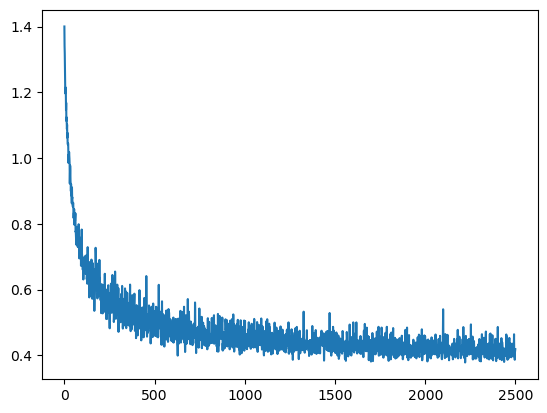

In [16]:
plt.plot(losses[:2500])

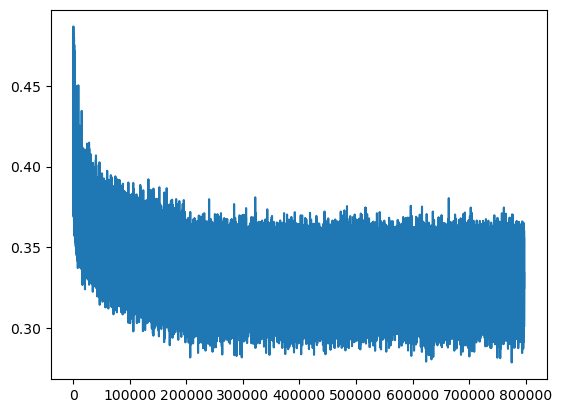

In [17]:
plt.plot(losses[2500:])

In [18]:
for i in range(10):
    print(generate_name())

bryn
sasinpie
sulassyngelika
jalain
elbirik
mari
aux
leo
nyla
mayon


In [19]:
inference(C, W1, b1, W2, b2, Xtr, Ytr)

tensor(2.1332, device='cuda:0', grad_fn=<NllLossBackward0>)

In [20]:
inference(C, W1, b1, W2, b2, Xte, Yte)

tensor(2.1600, device='cuda:0', grad_fn=<NllLossBackward0>)

In [21]:
if EMB_DIM == 2:
    Ccpu = C.cpu().detach().numpy()
    
    plt.figure(figsize=(8, 8))
    plt.scatter(Ccpu[:, 0], Ccpu[:, 1], s=200)
    for i in range(Ccpu.shape[0]):
        plt.text(Ccpu[i, 0], Ccpu[i, 1], chars[i], ha="center", va="center", color="white")
    plt.show()

/tmp/ipykernel_747196/369240412.py:3: RuntimeWarning: divide by zero encountered in log
  dy = np.log(d)


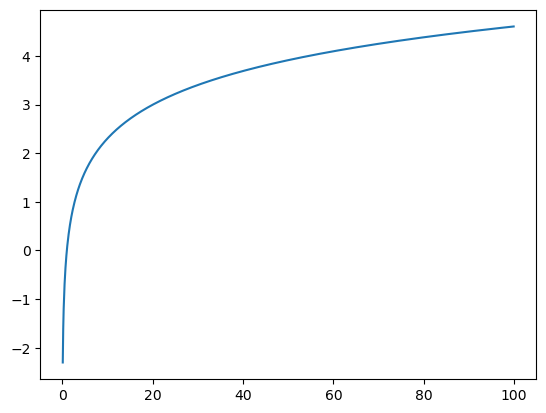

In [31]:
import numpy as np
d = np.arange(0., 100., 0.1)
dy = np.log(d)
plt.plot(d, dy)